In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd

# Load the dataset
df = pd.read_csv('Phishing Websites Engineered.csv')

# Features and target
X = df.drop(columns='target')
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)

In [11]:
y_pred = clf.predict(X_test)

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9461538461538461
              precision    recall  f1-score   support

          -1       0.96      0.94      0.95       620
           1       0.93      0.95      0.94       550

    accuracy                           0.95      1170
   macro avg       0.95      0.95      0.95      1170
weighted avg       0.95      0.95      0.95      1170



🔍 SHAP Summary Plot - MLP


<ipython-input-15-523a06e6de67>:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(mlp_shap_values, sample)


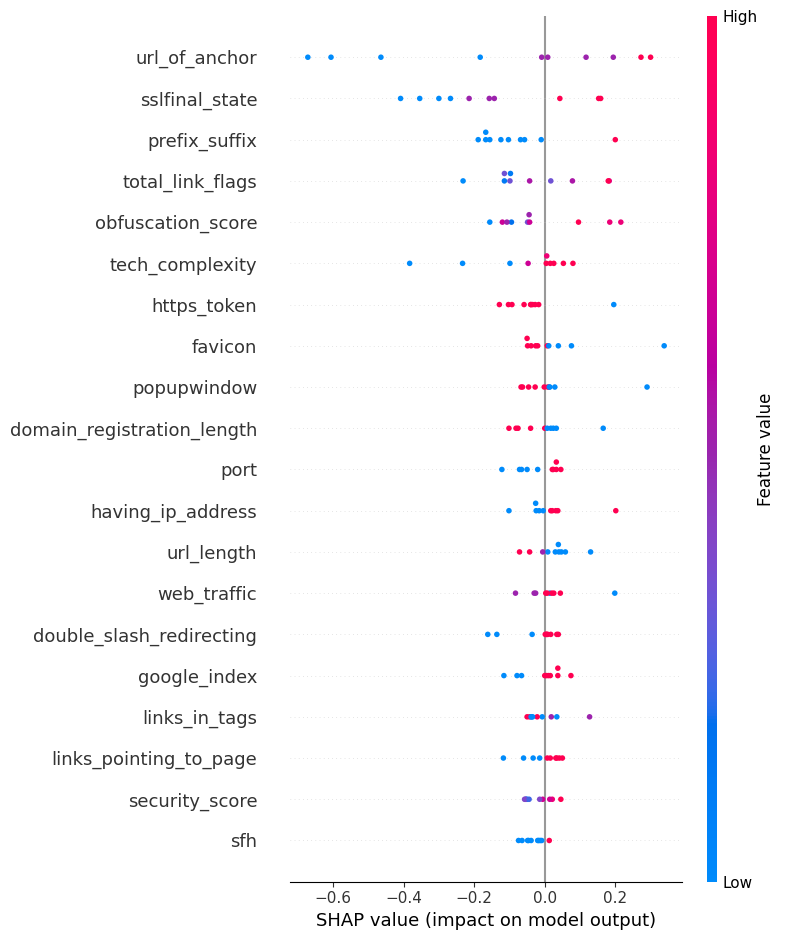

In [15]:
import shap
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP explainers for each model
mlp_explainer = shap.Explainer(clf.predict, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
mlp_shap_values = mlp_explainer(sample)

# Visualize summary plots
print("🔍 SHAP Summary Plot - MLP")
shap.summary_plot(mlp_shap_values, sample)


In [16]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3cec39aa0bf5dbedeac307cf1c31c4a5bbfdc6f39b793a253d94f3c64ce79b9b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [17]:
import lime
import lime.lime_tabular
import numpy as np


In [18]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [19]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [20]:
# Explain one instance with each model
explain_instance_lime(clf, "MLP")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: MLP on instance 224


## Feature Importance via Coefficients

In [24]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

top_features = coef_df['Feature'].head(5).tolist()

print("Top 5 Feature Importances:\n", coef_df.head())

Top 5 Feature Importances:
               Feature  Importance
13      url_of_anchor    0.093248
7      sslfinal_state    0.054957
30   total_link_flags    0.026581
5       prefix_suffix    0.023590
32  obfuscation_score    0.020342


# LOFO

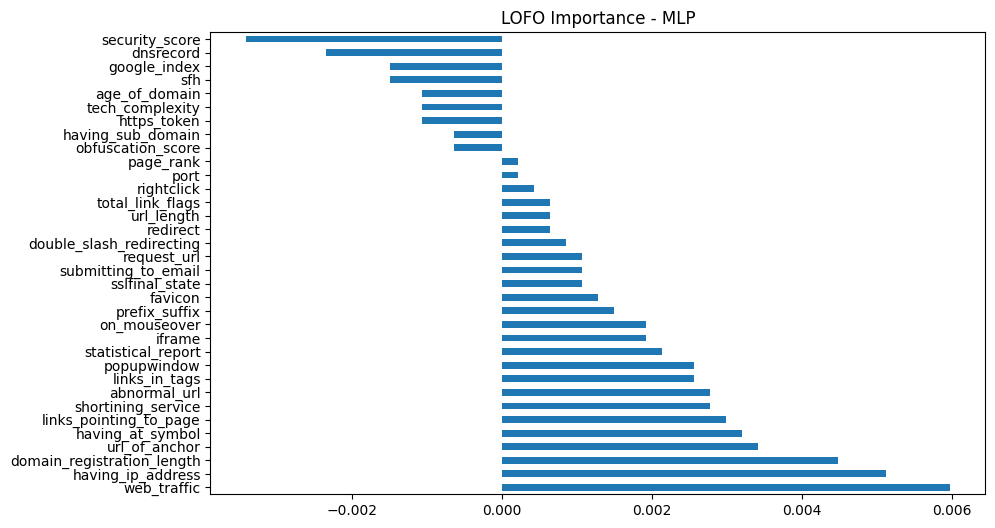

In [26]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
baseline = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(clf, X_lofo, y_train, cv=5, scoring='accuracy').mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - MLP")
plt.show()

In [27]:
print("Top 5 Features by LOFO Importance:")
print(lofo_df.head())

Top 5 Features by LOFO Importance:
web_traffic                   0.005983
having_ip_address             0.005129
domain_registration_length    0.004486
url_of_anchor                 0.003418
having_at_symbol              0.003205
dtype: float64


# PFI

Top 5 Features by Permutation Feature Importance (PFI):
              Feature  Importance
13      url_of_anchor    0.093248
7      sslfinal_state    0.054957
30   total_link_flags    0.026581
5       prefix_suffix    0.023590
32  obfuscation_score    0.020342


<Figure size 1000x600 with 0 Axes>

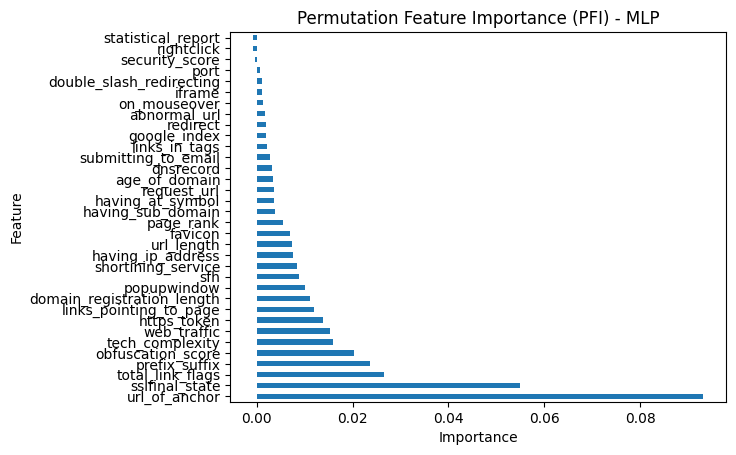

In [28]:
from sklearn.inspection import permutation_importance

pfi_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 5 Features by Permutation Feature Importance (PFI):")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - MLP")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
